### **Vehicle Dataset**


<p align="center"><img src="https://miro.medium.com/max/700/1*4YA07rUW8DTBs4ji3mDy0A.png" width="70%"/> 



### **Load data**


After some preprocessing 2 Dataset are collected and combining to get larger varient images i.e from

- [Vehicle Image Database](https://www.gti.ssr.upm.es/data/Vehicle_database.html)
- [Non vehicle dataset](https://www.dropbox.com/s/3kcbbvau7mnqzwe/non-vehicles.zip?dl=0) and [Vehicle dataset](https://www.dropbox.com/s/gwgvzm2ek9zx984/vehicles.zip?dl=0) From [Kitti benchmark](http://www.cvlibs.net/datasets/kitti/eval_object.php?obj_benchmark) 


Download the dataset by visiting the [Here](https://drive.google.com/file/d/1We-SS-jB-mZqn_K2SZlgZuuyNlILDiuJ/view?usp=sharing) and click the “Download All” button.

After that extract the downloaded folder.
<hr/>

### **`Folder structure`**

<hr/>

📁 Vehicle Dataset <br/>
&nbsp;&nbsp;&nbsp; 📁 non-vehicle <br/>
&nbsp;&nbsp;&nbsp; 📁 vehicle <br/>

    |__ non-vehicle
        |______ [1.png, 2.png, 3.png, 4.png, .... 8969.png]
    |__ vehicle
        |______ [1.png, 2.png, 3.png, 4.png, .... 8791.png ]

One of great source related to Vehicle dataset are present [here](https://lionbridge.ai/datasets/250000-cars-top-10-free-vehicle-image-and-video-datasets-for-machine-learning/)

### Import Package

In [ ]:
# Importing the necessary modules

from skimage.feature import hog
from skimage.transform import pyramid_gaussian
from skimage.io import imread
from sklearn.externals import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from skimage import color
from imutils.object_detection import non_max_suppression
import imutils
import numpy as np
import argparse
import cv2
import os
import glob
from PIL import Image # This will be used to read/modify images (can be done via OpenCV too)
from numpy import *
%matplotlib inline 
import matplotlib.pyplot as plt

In [ ]:
# Mount Drive

from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
!ls "/content/drive/My Drive/Colab Notebooks/Deep-learning-for-computer-vision/Histogram + SVM"

HOG-SVM-Object-Detection.ipynb	Vehicle_Dataset.zip


### **`Extract Dataset`**

In [ ]:
print("[INFO] Extracting Dataset .....")
!unzip -q "/content/drive/My Drive/Colab Notebooks/Deep-learning-for-computer-vision/Histogram + SVM/Vehicle_Dataset.zip"


[INFO] Extracting Dataset .....


In [ ]:
os.listdir('Vehicle_Dataset')

['non-vehicles', 'vehicles']

In [ ]:
non_vehicle_path = os.path.join('Vehicle_Dataset/non-vehicles')
vehicle_path = os.path.join('Vehicle_Dataset/vehicles')

non_vehicle_image = len([i for i in os.listdir(non_vehicle_path)])
vehicle_image = len([i for i in os.listdir(vehicle_path)])

print("Total non vehicle images : {}".format(non_vehicle_image))
print("Total vehicle images : {}".format(vehicle_image))

Total non vehicle images : 8968
Total vehicle images : 8791


### **Non vehicle image**

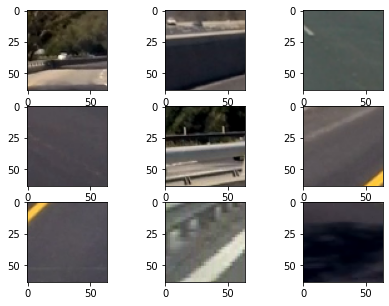

In [ ]:
from matplotlib.image import imread

plt.figure(figsize=(7,5))
for index, file in enumerate(os.listdir(non_vehicle_path),1):
  if index>9:
    break
  img_path = non_vehicle_path + '/'+file
  plt.subplot(3,3,index)
  img = imread(img_path)
  plt.imshow(img)

plt.show()

## **Vehicle Image**

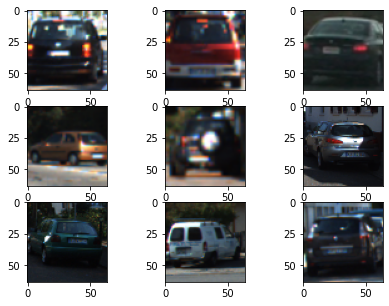

In [ ]:
from matplotlib.image import imread

plt.figure(figsize=(7,5))
for index, file in enumerate(os.listdir(vehicle_path),1):
  if index>9:
    break
  img_path = vehicle_path + '/'+file
  plt.subplot(3,3,index)
  img = imread(img_path)
  plt.imshow(img)

plt.show()

## **Image size**

In [ ]:
test_image = Image.open(non_vehicle_path + '/1.png')
print(test_image.size)

(64, 64)


## **Overview of performing car detection using HOG+SVM**

* Performed a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images.

* Trained a classifier with the set of vehicle and non-vehicle images.

* Implemented a sliding window to get subregions of a single video frame

* Used trained classifier to detect vehicles on subregions.

#### **HISTOGRAM OF ORIENTED GRADIENTS**

A class of objects such as a vehicle vary so much in color. Structural cues like shape give a more robust representation. Gradients of specific directions captures some notion of shape. To allow for some variability in shape, we’ll use features known as Histogram of Oriented Gradients (HOG).


<p align="center"><img src="https://miro.medium.com/max/700/1*fECFU2lAmFsSoYTPF5yqPQ.png" width="70%"/>

The idea of HOG is instead of using each individual gradient direction of each individual pixel of an image, we group the pixels into small cells. For each cell, we compute all the gradient directions and group them into a number of orientation bins. We sum up the gradient magnitude in each sample. So stronger gradients contribute more weight to their bins, and effects of small random orientations due to noise is reduced. This histogram gives us a picture of the dominant orientation of that cell. Doing this for all cells gives us a representation of the structure of the image. The HOG features keep the representation of an object distinct but also allow for some variations in shape.

<p align="center"><img src="https://miro.medium.com/max/700/1*aaUIQTyIyaQn2la-XlUxow.png" width="70%"/>


<p align="center"><img src="https://miro.medium.com/max/700/1*gUU4vLLFe_C7mNiJVKBGqQ.png" width="70%"/>



#### **Feature extraction**

We can specify the number of orientations, pixels_per_cell , and cells_per_block for computing the HOG features of a single channel of an image. The number of orientations is the number of orientation bins that the gradients of the pixels of each cell will be split up in the histogram. The pixels_per_cells is the number of pixels of each row and column per cell over each gradient the histogram is computed. The cells_per_block specifies the local area over which the histogram counts in a given cell will be normalized. Having this parameter is said to generally lead to a more robust feature set. We can also use the normalization scheme called transform_sqrt which is said to help reduce the effects of shadows and illumination variations.


<p align="center"><img src="https://miro.medium.com/max/700/1*p1YeuMBDpbVj39Y0VOQLHQ.png" width="70%"/>


<p align="center"><img src="https://miro.medium.com/max/700/1*Sf8au_GPR-lNzv12tKWZFQ.png" width="70%"/>

References :

* [Vehicle Detection with HOG and Linear SVM - Mithi](https://medium.com/@mithi/vehicles-tracking-with-hog-and-linear-svm-c9f27eaf521a)


### **Data loader**

In [ ]:
# define parameters of HOG feature extraction
orientations = 9
pixels_per_cell = (8, 8)
cells_per_block = (2, 2)
threshold = 0.3

In [ ]:
# Read the image files
pos_img_list = os.listdir(vehicle_path) # it will read all the files in the positive image path (so all the required images)
neg_img_list = os.listdir(non_vehicle_path)

In [ ]:
pos_img_list[:4]

['1421.png', '1095.png', '7426.png', '2856.png']

In [ ]:
# Define Data and Label

'''
Data : List Contain both postive and negative images
Labels : List Contain 1 or 0 based on pos and neg images
'''
data = []    
labels = []

In [ ]:
from skimage.feature import hog?

### **Visualize Hog Feature for vehicle image**

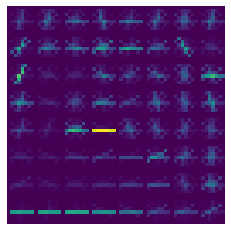

In [ ]:
from skimage import exposure

'''
when we use visualize=True the output will be in the form tuple 
one is 1D feature vector and other is extracted hog feature
'''

image = Image.open(vehicle_path + '/' + pos_img_list[0])
image = image.convert('L')
(H, hogImage) = hog( image,orientations, pixels_per_cell,
                                 cells_per_block, block_norm='L2-Hys',
                                 visualize=True, transform_sqrt=True,
                                 feature_vector=True)

hogImage = exposure.rescale_intensity(hogImage, out_range=(0, 255))
hogImage = hogImage.astype("uint8")
 
plt.imshow(hogImage, interpolation='nearest')
plt.axis('Off')
plt.show()
# cv2.imshow("HOG Image", hogImage)


### **Visualize Hog Feature for non-vehicle image**

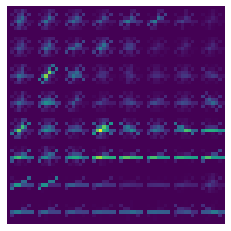

In [ ]:
image = Image.open(non_vehicle_path + '/' + neg_img_list[0])
image = image.convert('L')
(H, neg_hogImage) = hog( image,orientations, pixels_per_cell,
                                 cells_per_block, block_norm='L2-Hys',
                                 visualize=True, transform_sqrt=True,
                                 feature_vector=True)

neg_hogImage = exposure.rescale_intensity(neg_hogImage, out_range=(0, 255))
neg_hogImage = neg_hogImage.astype("uint8")
 
plt.imshow(neg_hogImage, interpolation='nearest')
plt.axis('Off')
plt.show()

### **Too visualize in actual gray scale instead of RGB**

Basically the problem is that gray = cv2.cvtColor(RGB_img, cv2.COLOR_RGB2GRAY) returns a single channel matrix, where as matplotlib is expecting a 3 channel RGB matrix to be shown, So you can either tell plt.imshow() that your input matrix is a single channel matrix using plt.imshow(gray, cmap='gray', vmin = 0, vmax = 255)

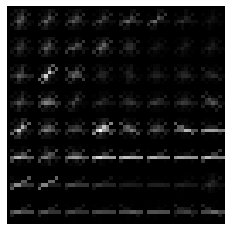

In [ ]:
image = Image.open(non_vehicle_path + '/' + neg_img_list[0])
image = image.convert('L')
(H, neg_hogImage) = hog( image,orientations, pixels_per_cell,
                                 cells_per_block, block_norm='L2-Hys',
                                 visualize=True, transform_sqrt=True,
                                 feature_vector=True)

neg_hogImage = exposure.rescale_intensity(neg_hogImage, out_range=(0, 255))
neg_hogImage = neg_hogImage.astype("uint8")
 
plt.imshow(neg_hogImage, interpolation='nearest',cmap='gray', vmin = 0, vmax = 255)
plt.axis('Off')
plt.show()

In [ ]:
## Fill vehicle i.e positive image in data and label them as 1

# this loop enables reading the files in the pos_img_list variable one by one

for i in pos_img_list:
  
  img = Image.open(vehicle_path + '/' + i)
  
  # convert the image into single channel i.e. RGB to grayscale
  img = img.convert('L')
  
  # calculate HOG for positive features
  pos_hog_feature = hog(img ,orientations, pixels_per_cell, 
            cells_per_block, block_norm='L2-Hys',
            transform_sqrt=True,feature_vector=True)
  
  data.append(pos_hog_feature)
  labels.append(1)

In [ ]:
print(pos_hog_feature.shape)    # 1D Feature vector
print(np.array(data).shape)     
print(labels.count(1))

(1764,)
(8791, 1764)
8791


In [ ]:
## Fill non-vehicle i.e negative image in data and label them as 0

## this loop enables reading the files in the pos_im_listing variable one by one

for i in neg_img_list:
  
  img = Image.open(non_vehicle_path + '/' + i)
  
  # convert the image into single channel i.e. RGB to grayscale
  img = img.convert('L')
  
  # calculate HOG for positive features
  neg_hog_feature = hog(img ,orientations, pixels_per_cell, 
            cells_per_block, block_norm='L2-Hys', 
            feature_vector=True,transform_sqrt=True)
  
  data.append(neg_hog_feature)
  labels.append(0)

In [ ]:
print(neg_hog_feature.shape)      # 1D Feature vector
print(np.array(data).shape)
print(labels.count(0))

(1764,)
(17759, 1764)
8968


In [ ]:
list(set(labels))

[0, 1]

In [ ]:
le = LabelEncoder()
labels = le.fit_transform(labels)
print(labels.shape)

(17759,)


### **Train test split**

In [ ]:
# Partitioning the data into training and testing splits, using 80%
# of the data for training and the remaining 20% for testing

print(" Constructing training/testing split...")
(trainData, testData, trainLabels, testLabels) = train_test_split(
	np.array(data), labels, test_size=0.20, random_state=42)

 Constructing training/testing split...


### **Train SVM Classifier**

In [ ]:
#%% Train the linear SVM
print(" Training Linear SVM classifier...")
model = LinearSVC()
model.fit(trainData, trainLabels)

 Training Linear SVM classifier...


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

### **Prediction on test dataset**

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metric import classification_report

prediction = model.predict(testData)
print(classification_report(testLabels,prediction))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1787
           1       0.96      0.95      0.95      1765

    accuracy                           0.96      3552
   macro avg       0.96      0.96      0.96      3552
weighted avg       0.96      0.96      0.96      3552



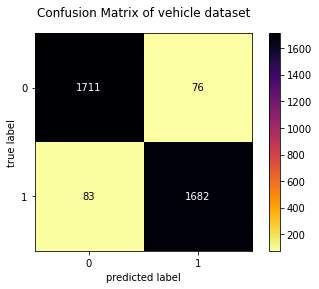

In [ ]:
from mlxtend.plotting import plot_confusion_matrix

cm = confusion_matrix(testLabels,prediction)
fig,ax = plot_confusion_matrix(conf_mat=cm, cmap='inferno_r',colorbar=True)
plt.title('Confusion Matrix of vehicle dataset')
plt.show()

### **Saving Model**

Pickled model as a file using joblib: Joblib is the replacement of pickle as it is more efficent on objects that carry large numpy arrays. These functions also accept file-like object instead of filenames.

* joblib.dump to serialize an object hierarchy
* joblib.load to deserialize a data stream

In [ ]:
joblib.dump(model, 'Vehicle_Classification_model.npy')

['Vehicle_Classification_model.npy']

In [ ]:
vehicle_model = joblib.load('Vehicle_Classification_model.npy')
# Image contains vehicle 
test = Image.open('1.png')

# convert the image into single channel i.e. RGB to grayscale
test = test.convert('L')

# calculate HOG for positive features
test_hog_feature = hog(test ,orientations, pixels_per_cell, 
                      cells_per_block, block_norm='L2-Hys',
                      transform_sqrt=True,feature_vector=True)

feature_detector = test_hog_feature.reshape(1,-1)
pred = vehicle_model.predict(feature_detector)
print("Predict output for vehicle image : ",pred[0])

Predict output for vehicle image :  1


### **Prediction**

In [ ]:
# Image contains vehicle 
test = Image.open('2.png')
  
# convert the image into single channel i.e. RGB to grayscale
test = test.convert('L')

# calculate HOG for positive features
test_hog_feature = hog(test ,orientations, pixels_per_cell, 
                      cells_per_block, block_norm='L2-Hys',
                      transform_sqrt=True,feature_vector=True)

feature_detector = test_hog_feature.reshape(1,-1)
pred = model.predict(feature_detector)
print("Predict output for non vehicle image : ",pred[0])

Predict output for non vehicle image :  0


### **Extracting testing**

Download the testing dataset from [here](https://drive.google.com/file/d/1FgFfjbLH8qMPHCiOBBpk3W_NuTk-hLn-/view?usp=sharing)

which contain both positive and negative dataset 

In [ ]:
print("[INFO] Extracting Dataset .....")
!unzip -q "/content/drive/My Drive/Colab Notebooks/Deep-learning-for-computer-vision/Histogram + SVM/Testing.zip"

[INFO] Extracting Dataset .....


In [ ]:
testing_folder = 'Testing'

number_of_test_image = len([i for i in os.listdir(testing_folder)])
print(number_of_test_image)

39


In [ ]:
test_filename = []
for i in os.listdir(testing_folder):
  test_filename.append(i)

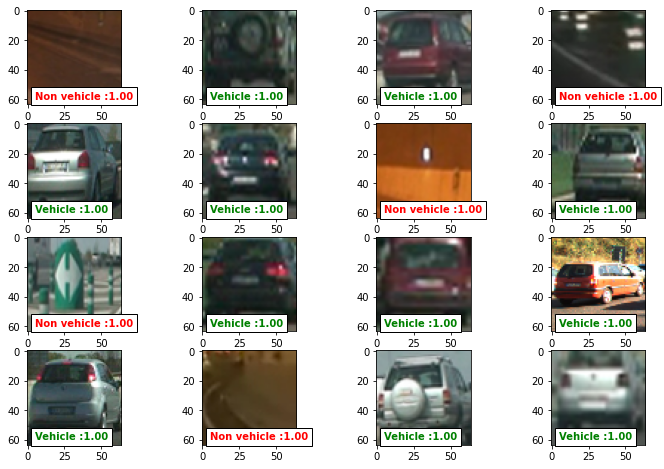

In [ ]:
import random
from keras.preprocessing.image import load_img

fig=plt.figure(figsize=(12, 8))
rows = 4
col = 4

## Select random number
testing_indices = random.sample(list(np.arange(1,number_of_test_image)),rows*col)

## Convert list into array
testing_indices = np.array(testing_indices)

# Get the testing image using list comprehension
test_images = np.stack(([ test_filename[i] for i in testing_indices ]))


for i in range(rows*col):
  fig.add_subplot(rows, col, i+1)

  img1 = load_img(testing_folder+'/'+test_images[i], target_size=(64,64))
      
  # convert the image into single channel i.e. RGB to grayscale
  test = img1.convert('L')

  # calculate HOG for positive features
  test_hog_feature = hog(test ,orientations, pixels_per_cell, 
                          cells_per_block, block_norm='L2-Hys',
                          transform_sqrt=True,feature_vector=True)

  feature_detector = test_hog_feature.reshape(1,-1)
  #pred = model.predict(feature_detector)

  prediction = model.predict(feature_detector) #gives all class prob.
  # print(prediction)
  if (prediction[0]==1):
    value ='Vehicle :%1.2f'%(prediction[0])
    plt.text(5,60,value,color='green',fontsize=10,weight='bold',bbox=dict(facecolor='white',alpha=1))
  else:
    value ='Non vehicle :%1.2f'%(1.0-prediction[0])
    plt.text(5,60,value,color='red',fontsize=10,weight='bold',bbox=dict(facecolor='white',alpha=1))
     
  plt.imshow(img1)

### **Build image pyramids**


The ``pyramid_gaussian`` function takes an image and yields successive images
shrunk by a constant scale factor. Image pyramids are often used, e.g., to
implement algorithms for denoising, texture discrimination, and scale-invariant
detection.

Reference : [https://scikit-image.org/docs/dev/api/skimage.transform.html#pyramid-gaussian](https://scikit-image.org/docs/dev/api/skimage.transform.html#pyramid-gaussian)

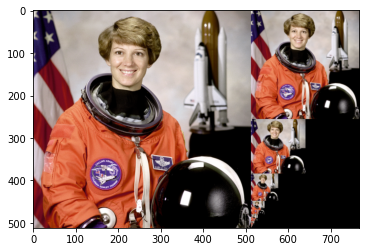

In [ ]:
from skimage import data


image = data.astronaut()
rows, cols, dim = image.shape
pyramid = tuple(pyramid_gaussian(image, downscale=2, multichannel=True))

composite_image = np.zeros((rows, cols + cols // 2, 3), dtype=np.double)

composite_image[:rows, :cols, :] = pyramid[0]

i_row = 0
for p in pyramid[1:]:
    n_rows, n_cols = p.shape[:2]
    composite_image[i_row:i_row + n_rows, cols:cols + n_cols] = p
    i_row += n_rows

fig, ax = plt.subplots()
ax.imshow(composite_image)
plt.show()

Read more about HOG and SVM from these blogs

* [Sample lesson on Histogram of Oriented Gradient ](https://gurus.pyimagesearch.com/lesson-sample-histogram-of-oriented-gradients-and-car-logo-recognition/)